# 0.Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram


from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

# 1.Clustering por tienda

In [2]:
# Abrimos el dataframe arreglado que creamos.
df= pd.read_csv("/Users/santi/Documents/csv/datos_arreglados.csv",index_col=0)

df["date"] = pd.to_datetime(df["date"])

df = df.set_index("date")

df.head()

,item,category,department,stores,region,week,year,is_holidays,units_sold,sell_price,total_sales
date,,,,,,,,,,,
2013-07-08,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,0,0,12.7414,0.0000
2013-07-15,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,1,0,12.7414,0.0000
2013-07-22,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,29,2013,0,4,10.9858,43.9432
2013-07-29,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,30,2013,0,6,10.9858,65.9148
2013-08-05,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,31,2013,0,0,10.9858,0.0000


In [3]:
# Comprobamos que los productos y los departamentos son iguales en todas las tiendas
df.groupby(["stores"]).agg({"item":"nunique",
                            "department":"nunique"}).reset_index()

,stores,item,department
0,Back_Bay(BOS_3),3049,7
1,Brooklyn(NYC_4),3049,7
2,Greenwich_Village(NYC_1),3049,7
3,Harlem(NYC_2),3049,7
4,Midtown_Village(PHI_1),3049,7
5,Queen_Village(PHI_3),3049,7
6,Roxbury(BOS_2),3049,7
7,South_End(BOS_1),3049,7
8,Tribeca(NYC_3),3049,7
9,Yorktown(PHI_2),3049,7


Ya que los departamentos y los ítems son iguales en todas las tiendas, procederemos a derecharlos para su clasificación. Realizaremos la agregación para quedarnos únicamente con la región, las unidades vendidas, el precio de venta y las ventas totales.

In [4]:
# Agrupamos por region, suma de unidades vendidas, precio de venta medio y el total de ventas.
df_tiendas = df.groupby(["stores"]).agg({"region":"first",
                                        "units_sold":"sum",
                                        "sell_price":"mean",
                                        "total_sales":"sum"}).reset_index()

df_tiendas

,stores,region,units_sold,sell_price,total_sales
0,Back_Bay(BOS_3),Boston,6057234,5.484508,2.181127e+07
1,Brooklyn(NYC_4),New York,4082201,5.522663,1.495885e+07
2,Greenwich_Village(NYC_1),New York,7657224,5.516056,2.757273e+07
3,Harlem(NYC_2),New York,5647131,5.576188,2.135534e+07
4,Midtown_Village(PHI_1),Philadelphia,5115653,5.580032,1.811085e+07
5,Queen_Village(PHI_3),Philadelphia,6391946,5.520492,2.063028e+07
6,Roxbury(BOS_2),Boston,7178136,5.455508,2.512650e+07
7,South_End(BOS_1),Boston,5567261,5.465372,1.923361e+07
8,Tribeca(NYC_3),New York,11134789,5.483638,3.928694e+07
9,Yorktown(PHI_2),Philadelphia,6506176,5.555507,2.152227e+07


Para realizar la segmentación, vamos a intentar seguir tres estrategias que consideramos podrían ser viables. Estas estrategias son las siguientes:

* Trabajar con el porcentaje de ventas de cada categoría: separando el porcentaje sobre el total de ventas por las tres grandes categorías.

* Trabajar con los tipos de productos segmentados: separando los productos por los cinco clusters que obtuvimos anteriormente.

* Trabajar con ambas segmentaciones al mismo tiempo: es decir, unir ambas clasificaciones para conseguir una segmentación más amplia. Sin embargo, es probable que esto no se pueda lograr, ya que al trabajar con tantas variables, la segmentación se vuelve más complicada debido a la dimensionalidad que se adquiere.

Después de analizar los tres enfoques, procederemos a seleccionar el enfoque que nos dé mejores resultados.

In [5]:
# Construimos los porcentajes de ventas por categoria 
df_cat = pd.crosstab(df["stores"],df["category"],values=df["total_sales"], aggfunc="sum",normalize="index").reset_index()
df_cat

category,stores,ACCESORIES,HOME_&_GARDEN,SUPERMARKET
0,Back_Bay(BOS_3),0.154744,0.290987,0.554269
1,Brooklyn(NYC_4),0.165118,0.256545,0.578337
2,Greenwich_Village(NYC_1),0.151246,0.269476,0.579278
3,Harlem(NYC_2),0.133760,0.389210,0.477030
4,Midtown_Village(PHI_1),0.170094,0.284054,0.545852
5,Queen_Village(PHI_3),0.104145,0.274484,0.621371
6,Roxbury(BOS_2),0.139968,0.293489,0.566543
7,South_End(BOS_1),0.113305,0.325477,0.561218
8,Tribeca(NYC_3),0.113925,0.332989,0.553085
9,Yorktown(PHI_2),0.086750,0.281245,0.632005


In [6]:
# Unimos las tablas para posteriormente trabajar las correlaciones lineales
df_cluster_cat= df_tiendas.merge(df_cat,on="stores")
df_cluster_cat.head()

,stores,region,units_sold,sell_price,total_sales,ACCESORIES,HOME_&_GARDEN,SUPERMARKET
0,Back_Bay(BOS_3),Boston,6057234,5.484508,2.181127e+07,0.154744,0.290987,0.554269
1,Brooklyn(NYC_4),New York,4082201,5.522663,1.495885e+07,0.165118,0.256545,0.578337
2,Greenwich_Village(NYC_1),New York,7657224,5.516056,2.757273e+07,0.151246,0.269476,0.579278
3,Harlem(NYC_2),New York,5647131,5.576188,2.135534e+07,0.133760,0.389210,0.477030
4,Midtown_Village(PHI_1),Philadelphia,5115653,5.580032,1.811085e+07,0.170094,0.284054,0.545852


/var/folders/h2/m__59kjn7y17pxmn41zlkfsm0000gn/T/ipykernel_69563/3507356647.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_cluster_cat.corr(), annot=True, cmap="YlGnBu")


<Axes: >

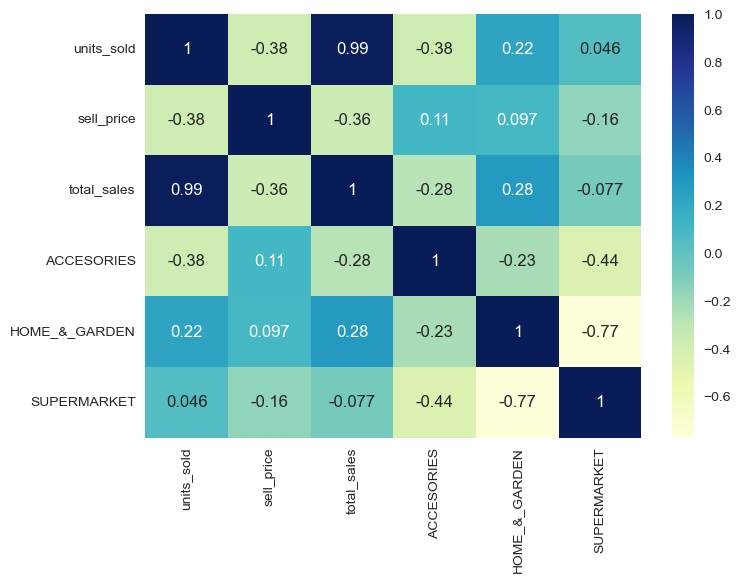

In [7]:
# Construimos el mapa de correlaciones lineales
sns.heatmap(df_cluster_cat.corr(), annot=True, cmap="YlGnBu")

In [8]:
# Realizamos la copia del df para eliminar variable correlacionadas y realizar las normalizaciones pertinentes.
df_cluster_1= df_cluster_cat.copy()

In [9]:
df_cluster_1.drop(columns=["total_sales","HOME_&_GARDEN","region"],inplace=True)
tiendas = df_cluster_1.pop("stores")
tiendas

0             Back_Bay(BOS_3)
1             Brooklyn(NYC_4)
2    Greenwich_Village(NYC_1)
3               Harlem(NYC_2)
4      Midtown_Village(PHI_1)
5        Queen_Village(PHI_3)
6              Roxbury(BOS_2)
7            South_End(BOS_1)
8              Tribeca(NYC_3)
9             Yorktown(PHI_2)
Name: stores, dtype: object

In [10]:
# Utilizamos el standard scaler ya que no contamos con outliers.
ss = StandardScaler()
df_cluster_ss = pd.DataFrame(
    ss.fit_transform(df_cluster_1),
    columns=df_cluster_1.columns)
df_cluster_ss

,units_sold,sell_price,ACCESORIES,SUPERMARKET
0,-0.262981,-0.750375,0.811173,-0.311947
1,-1.352909,0.158874,1.203697,0.282505
2,0.619979,0.001414,0.678823,0.305753
3,-0.489297,1.434361,0.017194,-2.219681
4,-0.782595,1.525974,1.391987,-0.519833
5,-0.078269,0.107134,-1.103348,1.345410
6,0.355593,-1.441436,0.252084,-0.008785
7,-0.533374,-1.206382,-0.756771,-0.140309
8,2.539084,-0.771115,-0.733294,-0.341183
9,-0.015231,0.941550,-1.761545,1.608069


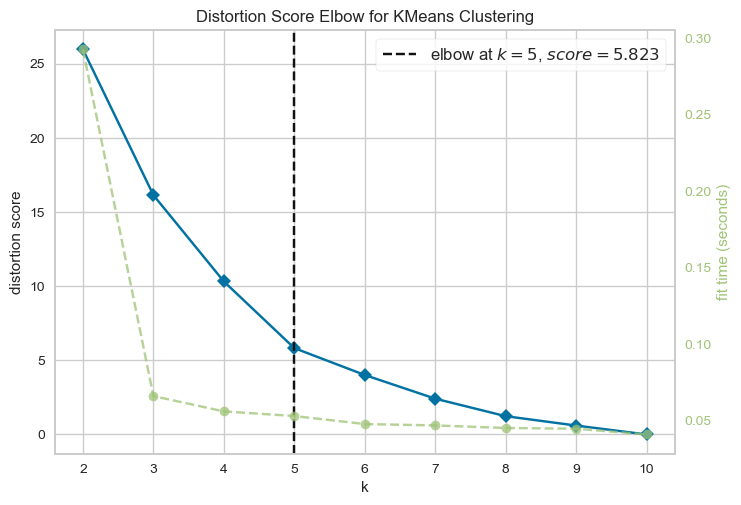

In [11]:
Elbow_M = KElbowVisualizer(KMeans(random_state=42, init="random", n_init="auto"), k=10)
Elbow_M.fit(df_cluster_ss)
Elbow_M.show();

In [12]:
silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")
    kmeans.fit(df_cluster_ss)
    silhouette_scores.append(silhouette_score(df_cluster_ss, kmeans.labels_))

fig = px.line(
    x=range(2, 10),
    y=silhouette_scores,
    title="Silhouette score",
    labels={"x": "k", "y": "Silhouette score"},
)
fig.show()

Al realizar las dos pruebas pertinentes para la elección del número de clústeres, comprobamos que la prueba de la silueta nos proporciona un resultado más alto en cuanto al número de clústeres, por lo que decidimos seleccionarla para aplicar el algoritmo en este caso.

In [13]:
kmeans= KMeans(n_clusters=3,random_state=42, init="random", n_init="auto")
kmeans.fit(df_cluster_ss)

KMeans(init='random', n_clusters=3, n_init='auto', random_state=42)

/Users/santi/anaconda3/envs/Nuclio/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



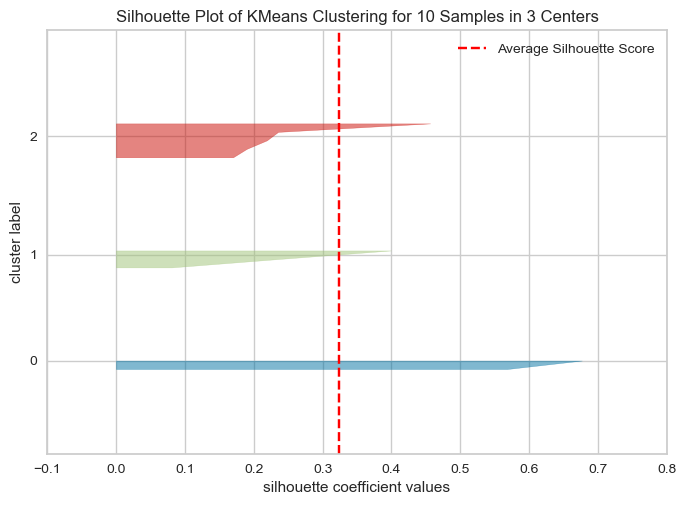

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [14]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(df_cluster_ss)  
visualizer.show()

Como se puede comprobar nos sale una segmentacion bastante correcta con los grupos bastante homogeneos entre si, ahora pasaremos a comprobar las otras caracteristicas como comentamos anteriormente.

In [15]:
# Cargamos el csv con los datos de clustering por productos y seleccionaremos las etiquetas de cluster
df_clustering= pd.read_csv("/Users/santi/Documents/csv/clusteringproducto.csv",index_col=0)
df_clustering.head()

,item,Q1,Q2,Q3,Q4,units_total,avg_price,cluster_hdbscan,cluster_kmeans
0,ACCESORIES_1_001,0.281263,0.195372,0.234402,0.288963,4051,11.000712,1,2
1,ACCESORIES_1_002,0.199654,0.190240,0.255982,0.354124,5047,5.279317,-1,3
2,ACCESORIES_1_003,0.289062,0.256714,0.227942,0.226282,1405,3.938599,1,3
3,ACCESORIES_1_004,0.266751,0.258757,0.229655,0.244836,38996,6.006287,1,3
4,ACCESORIES_1_005,0.234197,0.202624,0.257898,0.305281,14529,3.807422,1,3


In [16]:
df_clustering_producto= df_clustering[["item","cluster_kmeans"]]
df_clustering_producto

,item,cluster_kmeans
0,ACCESORIES_1_001,2
1,ACCESORIES_1_002,3
2,ACCESORIES_1_003,3
3,ACCESORIES_1_004,3
4,ACCESORIES_1_005,3
...,...,...
3044,SUPERMARKET_3_823,3
3045,SUPERMARKET_3_824,3
3046,SUPERMARKET_3_825,3
3047,SUPERMARKET_3_826,3


In [17]:
# Unimos los dataframes para obtener la informacion de ventas por cluster
df = df.merge(df_clustering_producto,how='inner',on="item")
df

,item,category,department,stores,region,week,year,is_holidays,units_sold,sell_price,total_sales,cluster_kmeans
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,0,0,12.7414,0.0000,2
1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,1,0,12.7414,0.0000,2
2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,29,2013,0,4,10.9858,43.9432,2
3,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,30,2013,0,6,10.9858,65.9148,2
4,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,31,2013,0,0,10.9858,0.0000,2
...,...,...,...,...,...,...,...,...,...,...,...,...
6610508,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village(PHI_3),Philadelphia,12,2016,1,22,1.2000,26.4000,0
6610509,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village(PHI_3),Philadelphia,13,2016,0,17,1.2000,20.4000,0
6610510,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village(PHI_3),Philadelphia,14,2016,0,6,1.2000,7.2000,0
6610511,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village(PHI_3),Philadelphia,15,2016,0,0,1.2000,0.0000,0


In [18]:
# Con el crosstab conseguimos el porcentaje de ventas sobre el total  de cada cluster de productos.
df_cluster_prod = pd.crosstab(df["stores"],df["cluster_kmeans"],values=df["total_sales"], aggfunc="sum",normalize="index").reset_index()
df_cluster_prod

cluster_kmeans,stores,0,1,2,3,4
0,Back_Bay(BOS_3),0.145008,0.042796,0.199867,0.447535,0.164793
1,Brooklyn(NYC_4),0.143173,0.038198,0.196859,0.509640,0.112130
2,Greenwich_Village(NYC_1),0.142830,0.042186,0.186286,0.480925,0.147773
3,Harlem(NYC_2),0.145409,0.042434,0.204674,0.501893,0.105592
4,Midtown_Village(PHI_1),0.173394,0.029018,0.189092,0.503709,0.104787
5,Queen_Village(PHI_3),0.165262,0.033962,0.153244,0.464291,0.183241
6,Roxbury(BOS_2),0.139974,0.044732,0.187042,0.461239,0.167014
7,South_End(BOS_1),0.143365,0.039495,0.175791,0.481745,0.159604
8,Tribeca(NYC_3),0.145207,0.038818,0.180096,0.476923,0.158956
9,Yorktown(PHI_2),0.210494,0.031089,0.144778,0.474031,0.139609


In [19]:
# Unimos el dataframe
df_cluster_tiendas_prod= df_tiendas.merge(df_cluster_prod,on="stores")
df_cluster_tiendas_prod.head()

,stores,region,units_sold,sell_price,total_sales,0,1,2,3,4
0,Back_Bay(BOS_3),Boston,6057234,5.484508,2.181127e+07,0.145008,0.042796,0.199867,0.447535,0.164793
1,Brooklyn(NYC_4),New York,4082201,5.522663,1.495885e+07,0.143173,0.038198,0.196859,0.509640,0.112130
2,Greenwich_Village(NYC_1),New York,7657224,5.516056,2.757273e+07,0.142830,0.042186,0.186286,0.480925,0.147773
3,Harlem(NYC_2),New York,5647131,5.576188,2.135534e+07,0.145409,0.042434,0.204674,0.501893,0.105592
4,Midtown_Village(PHI_1),Philadelphia,5115653,5.580032,1.811085e+07,0.173394,0.029018,0.189092,0.503709,0.104787


In [20]:
# Renombramos para comprobar las correlaciones entre columnas
df_cluster_tiendas_prod = df_cluster_tiendas_prod.rename(columns={0:'cluster0', 1:'cluster1', 2:'cluster2', 3:'cluster3', 4:'cluster4'})

/var/folders/h2/m__59kjn7y17pxmn41zlkfsm0000gn/T/ipykernel_69563/3753470827.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

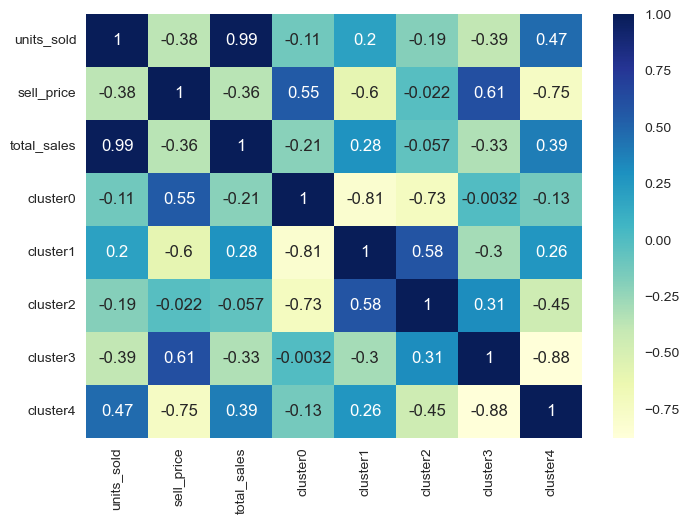

In [21]:
sns.heatmap(df_cluster_tiendas_prod.corr(), annot=True, cmap="YlGnBu")

In [23]:
# Creamos una copia del dataframe
df_cluster_prod= df_cluster_tiendas_prod.copy()

# Eliminamos columnas correlacionadas
df_cluster_prod.drop(columns=["total_sales","cluster0","cluster3","region"],inplace=True)
tiendas = df_cluster_prod.pop("stores")
tiendas

0             Back_Bay(BOS_3)
1             Brooklyn(NYC_4)
2    Greenwich_Village(NYC_1)
3               Harlem(NYC_2)
4      Midtown_Village(PHI_1)
5        Queen_Village(PHI_3)
6              Roxbury(BOS_2)
7            South_End(BOS_1)
8              Tribeca(NYC_3)
9             Yorktown(PHI_2)
Name: stores, dtype: object

In [24]:
# Normalizamos los valores

ss = StandardScaler()
df_cluster_ss_pr = pd.DataFrame(
    ss.fit_transform(df_cluster_prod),
    columns=df_cluster_prod.columns)
df_cluster_ss_pr

,units_sold,sell_price,cluster1,cluster2,cluster4
0,-0.262981,-0.750375,0.900237,0.980980,0.771049
1,-1.352909,0.158874,-0.014844,0.817881,-1.215202
2,0.619979,0.001414,0.778832,0.244681,0.129103
3,-0.489297,1.434361,0.828177,1.241558,-1.461802
4,-0.782595,1.525974,-1.841942,0.396821,-1.492163
5,-0.078269,0.107134,-0.858008,-1.546690,1.466815
6,0.355593,-1.441436,1.285619,0.285652,0.854802
7,-0.533374,-1.206382,0.243237,-0.324324,0.575316
8,2.539084,-0.771115,0.108456,-0.090904,0.550896
9,-0.015231,0.941550,-1.429765,-2.005655,-0.178816


Después de todas las transformaciones, pasamos a comprobar a través de la prueba del codo y la silueta cuál sería el número correcto de clusters.

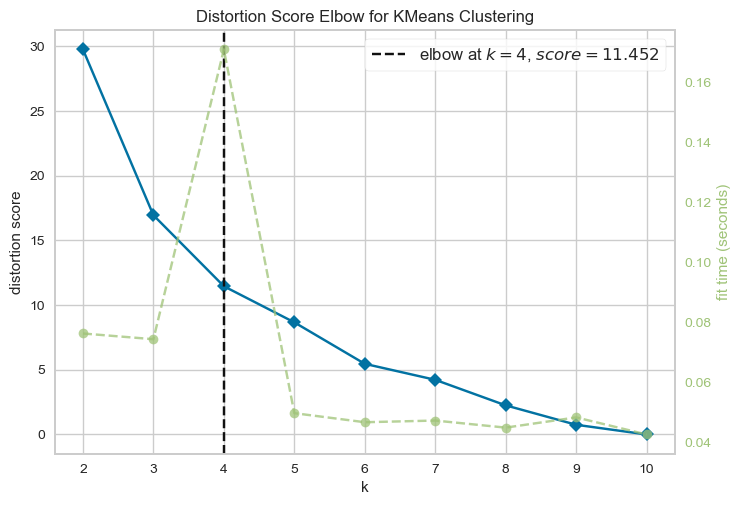

In [25]:
Elbow_M = KElbowVisualizer(KMeans(random_state=42, init="random", n_init="auto"), k=10)
Elbow_M.fit(df_cluster_ss_pr)
Elbow_M.show();

In [26]:
silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")
    kmeans.fit(df_cluster_ss_pr)
    silhouette_scores.append(silhouette_score(df_cluster_ss, kmeans.labels_))

fig = px.line(
    x=range(2, 10),
    y=silhouette_scores,
    title="Silhouette score",
    labels={"x": "k", "y": "Silhouette score"},
)
fig.show()

Como ocurría anteriormente, nos decantaremos por el número de clusters que nos indica la prueba de la silueta.

In [27]:
kmeans= KMeans(n_clusters=3,random_state=42, init='k-means++', n_init="auto")
kmeans.fit(df_cluster_ss_pr)

KMeans(n_clusters=3, n_init='auto', random_state=42)

/Users/santi/anaconda3/envs/Nuclio/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



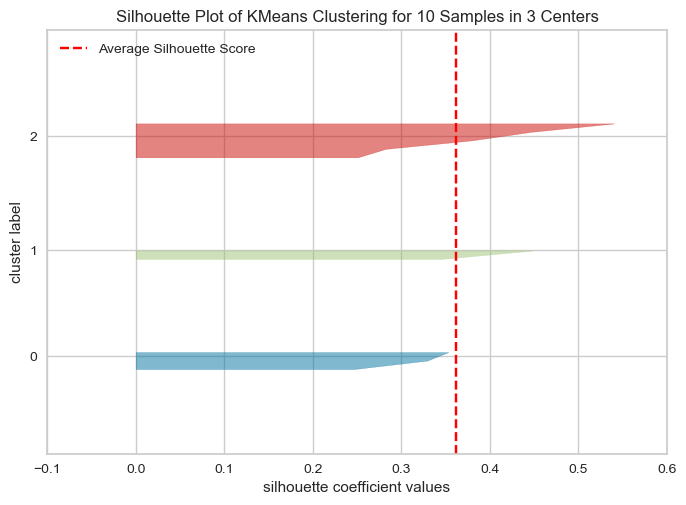

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [28]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(df_cluster_ss_pr)  
visualizer.show()

Después de la evaluación con la prueba de la SilhouetteVisualizer, comprobamos cómo esta segmentación tiene una mayor homogeneidad respecto a la anterior. Aunque quedaría analizar si estos clusters tienen sentido. Primero, trataremos de combinar ambas clasificaciones.

In [29]:
df_completo = df_cluster_tiendas_prod.merge(df_cat,how="inner",on="stores")

/var/folders/h2/m__59kjn7y17pxmn41zlkfsm0000gn/T/ipykernel_69563/2410935354.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

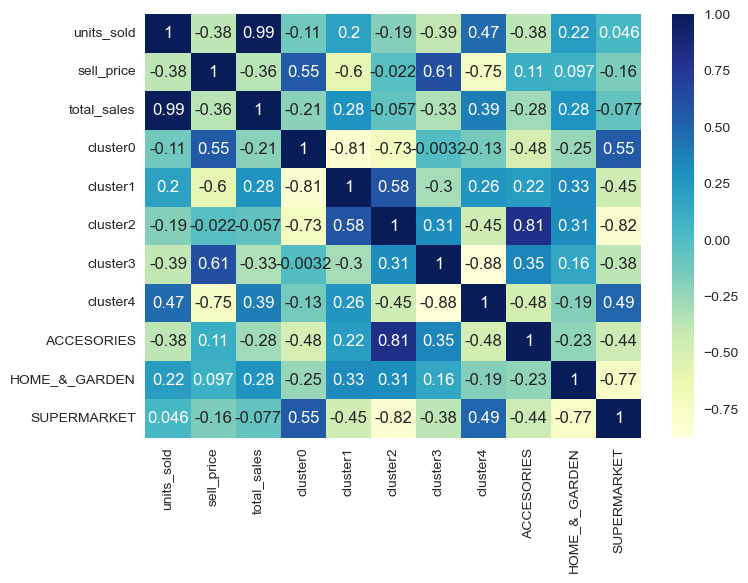

In [30]:
sns.heatmap(df_completo.corr(), annot=True, cmap="YlGnBu")

In [31]:
# Como haciamos anteriormente eliminamos las columnas correlacionadas.
df_completo.drop(columns=["total_sales","cluster0","cluster3","total_sales","HOME_&_GARDEN","region"],inplace=True)
tiendas = df_completo.pop("stores")
tiendas

0             Back_Bay(BOS_3)
1             Brooklyn(NYC_4)
2    Greenwich_Village(NYC_1)
3               Harlem(NYC_2)
4      Midtown_Village(PHI_1)
5        Queen_Village(PHI_3)
6              Roxbury(BOS_2)
7            South_End(BOS_1)
8              Tribeca(NYC_3)
9             Yorktown(PHI_2)
Name: stores, dtype: object

In [32]:
ss = StandardScaler()
df_cluster_ss_pr = pd.DataFrame(
    ss.fit_transform(df_completo),
    columns=df_completo.columns)
df_cluster_ss_pr

,units_sold,sell_price,cluster1,cluster2,cluster4,ACCESORIES,SUPERMARKET
0,-0.262981,-0.750375,0.900237,0.980980,0.771049,0.811173,-0.311947
1,-1.352909,0.158874,-0.014844,0.817881,-1.215202,1.203697,0.282505
2,0.619979,0.001414,0.778832,0.244681,0.129103,0.678823,0.305753
3,-0.489297,1.434361,0.828177,1.241558,-1.461802,0.017194,-2.219681
4,-0.782595,1.525974,-1.841942,0.396821,-1.492163,1.391987,-0.519833
5,-0.078269,0.107134,-0.858008,-1.546690,1.466815,-1.103348,1.345410
6,0.355593,-1.441436,1.285619,0.285652,0.854802,0.252084,-0.008785
7,-0.533374,-1.206382,0.243237,-0.324324,0.575316,-0.756771,-0.140309
8,2.539084,-0.771115,0.108456,-0.090904,0.550896,-0.733294,-0.341183
9,-0.015231,0.941550,-1.429765,-2.005655,-0.178816,-1.761545,1.608069


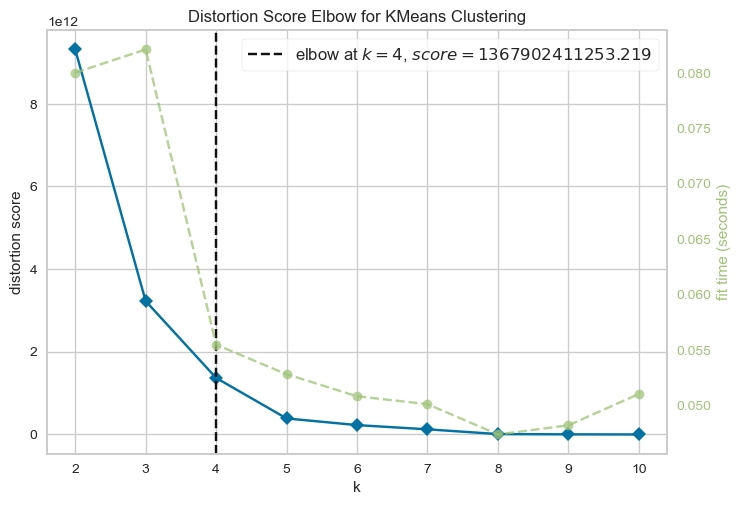

In [33]:
Elbow_M = KElbowVisualizer(KMeans(random_state=42, init="random", n_init="auto"), k=10)
Elbow_M.fit(df_completo)
Elbow_M.show();

In [34]:
silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")
    kmeans.fit(df_completo)
    silhouette_scores.append(silhouette_score(df_cluster_ss, kmeans.labels_))

fig = px.line(
    x=range(2, 10),
    y=silhouette_scores,
    title="Silhouette score",
    labels={"x": "k", "y": "Silhouette score"},
)
fig.show()

Como se comprueba al aumentar la dimensionalidad la prueba de la silhoueta pierde eficiencia ya que la distancias son mayores, en este caso utilizaremos la prueba del codo y comprobaremos con los visuzliadores de shiolueta si consigue una segmentación adecuada. 

In [36]:
# Seleccionamos el numero de clusters.
kmeans= KMeans(n_clusters=4,random_state=42, init='k-means++', n_init="auto")
kmeans.fit(df_completo)

KMeans(n_clusters=4, n_init='auto', random_state=42)

/Users/santi/anaconda3/envs/Nuclio/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



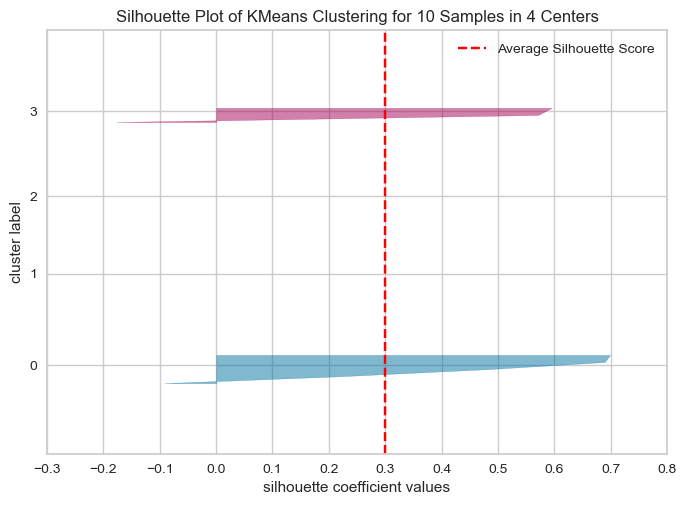

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [37]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(df_completo)  
visualizer.show()

Como se puede comprobar estas clasificación empeora respecto a las dos anteriores, debido al aumento de la dimensionalidad, por lo que la descartaremos ya que no funciona como se podria esperar.

In [38]:
# Aplicamos el algoritmo al primer dataframe con los porcentaje de ventas sobre el total de los departamentos. 
kmeans= KMeans(n_clusters=3,random_state=42, init='k-means++', n_init="auto")
kmeans.fit(df_cluster_ss)

KMeans(n_clusters=3, n_init='auto', random_state=42)

In [39]:
df_cluster_cat["cluster"]= kmeans.labels_
df_cluster_cat

,stores,region,units_sold,sell_price,total_sales,ACCESORIES,HOME_&_GARDEN,SUPERMARKET,cluster
0,Back_Bay(BOS_3),Boston,6057234,5.484508,2.181127e+07,0.154744,0.290987,0.554269,2
1,Brooklyn(NYC_4),New York,4082201,5.522663,1.495885e+07,0.165118,0.256545,0.578337,2
2,Greenwich_Village(NYC_1),New York,7657224,5.516056,2.757273e+07,0.151246,0.269476,0.579278,2
3,Harlem(NYC_2),New York,5647131,5.576188,2.135534e+07,0.133760,0.389210,0.477030,0
4,Midtown_Village(PHI_1),Philadelphia,5115653,5.580032,1.811085e+07,0.170094,0.284054,0.545852,0
5,Queen_Village(PHI_3),Philadelphia,6391946,5.520492,2.063028e+07,0.104145,0.274484,0.621371,1
6,Roxbury(BOS_2),Boston,7178136,5.455508,2.512650e+07,0.139968,0.293489,0.566543,2
7,South_End(BOS_1),Boston,5567261,5.465372,1.923361e+07,0.113305,0.325477,0.561218,1
8,Tribeca(NYC_3),New York,11134789,5.483638,3.928694e+07,0.113925,0.332989,0.553085,1
9,Yorktown(PHI_2),Philadelphia,6506176,5.555507,2.152227e+07,0.086750,0.281245,0.632005,1


El clustering aplicado a la segmentación por productos presenta una separación correcta, pero la explicabilidad en comparación con la segmentación por departamentos es menor. Por ello, aunque el enfoque de estas dos segmentaciones tenga resultados similares, nos quedamos con la segmentación por departamentos.

* El Clúster 0 agrupa las tiendas con el precio más alto por producto vendido, lo que explica, junto a la tienda de Brooklyn del Clúster 1, su menor volumen de ventas general. En cuanto a la distribución de ventas por categoría, se observa una combinación de productos de supermercado (que representan la mayor parte de la facturación) con artículos más costosos de la categoría Hogar y Jardín, mientras que las ventas de Accesorios son considerablemente menores.

* El Clúster 1 se distingue por agrupar tiendas con un precio medio por producto vendido en comparación con los otros dos grupos, y una notable variabilidad en las unidades vendidas. En contraste con los demás clústeres, la sección de Accesorios presenta un porcentaje de ventas inferior, mientras que las ventas se concentran principalmente en Supermercado, con un ligero incremento en la categoría Hogar y Jardín.

* El Clúster 2 se caracteriza por presentar un mayor equilibrio en las ventas porcentuales en comparación con los otros dos grupos, ubicándose en un punto intermedio entre ellos. El precio medio de sus productos se encuentra en el rango central, al igual que sus ventas totales, lo que refleja una distribución más homogénea.


Aunque contamos con la limitación de tener pocos clusters y las características de nuestras tiendas centradas únicamente en parámetros numéricos, podemos observar algunos insights que podrían ser valiosos para el equipo de negocios al comparar cómo se comportan estas tiendas entre sí y cómo los productos se comportan dependiendo de estas segmentaciones creadas entre sí.
